In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms, datasets
from sklearn.metrics import precision_recall_fscore_support
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchinfo
import time
from torchmetrics.classification import MulticlassROC
from sklearn.metrics import confusion_matrix

In [376]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 32

# Load the dataset
dataset = datasets.ImageFolder(root='./cnn_dataset/', transform=transform)

# Dataset split into training, validation and testing set
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [377]:
# Check image channel if 1, grayscale image if 3, RGB image
for image,label in trainloader:
    print(image.shape[1])
    break

3


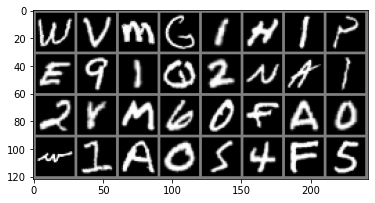

W     V     M     G     I     H     I     P     E     9     L     Q     2     N     A     I     2     Y     M     6     0     F     A     O     W     1     A     O     S     4     F     5    


In [378]:
classes = dataset.classes
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))



### Define a Convolutional Neural Network

1. How many input neurons are there?<br>
--> image size = 28\*28 and channels = 3. Therefore, number of input neurons = 28\*28\*3 = <b>2352</b><br>
1. How many output neurons are there?<br>
--> number of output neurons = number of classes in final layer i.e. fc3 = <b>36</b><br>
1. What activation function is used for the hidden layers?<br>
--> <b>ReLU</b> activation function is used for hidden layers<br>
1. What activation function is used for the output layer? <br>
--> No activation function is used while defining CNN for output layers. It simply outputs logits and later we use <b>Softmax</b> activation function for computing classifications.<br>
1. What is the number of hidden layers?<br>
--> Total number of layers = <b>5</b>, in which conv1 is input layer and fc3 is output layer. Therefore, hidden layer = total layers - input layer - output layer = 5 - 1 - 1 = <b>3</b><br>
1. What is the kernel size, number of filters, strides, paddings and other CNN-parameters?<br>
--> For conv1: Kernel size = <b>5x5</b>, number of filters = <b>6</b>, Similarly, for conv2: Kernel size = <b>5x5</b>, number of filters = <b>16</b>. Max pooling layer: Kernel size = <b>2*2</b>, stride = <b>2</b>, Padding is not mentioned: therefore default Padding value is used i.e. <b>0</b><br>
1. Do you include Dropout?<br>
--> <b>No</b> Dropout isn't included

In [379]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 36)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [380]:
modelCNN = CNN()
print(modelCNN)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=36, bias=True)
)


In [381]:
# Torchinfo Summary
torchinfoSummary = torchinfo.summary(modelCNN, input_data=torch.randn(batch_size, 3, 28, 28)) #batch_size=16, channels=3, height=28, width=28
print(torchinfoSummary)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [32, 36]                  --
├─Conv2d: 1-1                            [32, 6, 24, 24]           456
├─MaxPool2d: 1-2                         [32, 6, 12, 12]           --
├─Conv2d: 1-3                            [32, 16, 8, 8]            2,416
├─MaxPool2d: 1-4                         [32, 16, 4, 4]            --
├─Linear: 1-5                            [32, 120]                 30,840
├─Linear: 1-6                            [32, 84]                  10,164
├─Linear: 1-7                            [32, 36]                  3,060
Total params: 46,936
Trainable params: 46,936
Non-trainable params: 0
Total mult-adds (M): 14.76
Input size (MB): 0.30
Forward/backward pass size (MB): 1.21
Params size (MB): 0.19
Estimated Total Size (MB): 1.70


In [382]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(modelCNN.parameters(), lr=0.001, momentum=0.9)

### Model Training

In [383]:
# Start time
startTime = time.time()

training_loss_plt_arr = []
validation_loss_plt_arr = []
testing_loss_plt_arr = []

epochs = 2
# Epoch Iteration
for epoch in range(epochs):
    training_loss = 0.0
    
    #Training loop
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = modelCNN(inputs)
        loss_training = criterion(outputs, labels)
        loss_training.backward()
        optimizer.step()

        training_loss += loss_training.item()
        if i % 500 == 499:
            
            # Validation loop
            validation_loss = 0.0
            with torch.no_grad():
                for data in valloader:
                    images, labels = data
                    outputs = modelCNN(images)
                    loss_validation = criterion(outputs, labels)
                    validation_loss += loss_validation.item()
            
            # Testing loop
            testing_loss = 0.0
            with torch.no_grad():
                for data in testloader:
                    images, labels = data
                    outputs = modelCNN(images)
                    loss_testing = criterion(outputs, labels)
                    testing_loss += loss_testing.item()

            print(f"[{epoch + 1}, {i + 1}], Training loss: {training_loss / 500:.3f}, Validation loss: {validation_loss / len(valloader):.3f}, Testing loss: {testing_loss / len(testloader):.3f}")
            training_loss_plt_arr.append(round((training_loss / 500),3))
            validation_loss_plt_arr.append(round((validation_loss / len(valloader)),3))
            testing_loss_plt_arr.append(round((testing_loss / len(testloader)),3))
            training_loss = 0.0

print("Finished Training")
    
# End time
endTime = time.time()
time_to_train = (endTime - startTime)
print(f"\nTime to train = {time_to_train:.2f}\n")

[1, 500], Training loss: 3.581, Validation loss: 3.574, Testing loss: 3.575
[1, 1000], Training loss: 3.534, Validation loss: 3.400, Testing loss: 3.403
[1, 1500], Training loss: 2.187, Validation loss: 1.386, Testing loss: 1.374
[1, 2000], Training loss: 1.066, Validation loss: 0.902, Testing loss: 0.889
[1, 2500], Training loss: 0.790, Validation loss: 0.765, Testing loss: 0.747
[2, 500], Training loss: 0.662, Validation loss: 0.659, Testing loss: 0.644
[2, 1000], Training loss: 0.601, Validation loss: 0.577, Testing loss: 0.569
[2, 1500], Training loss: 0.524, Validation loss: 0.535, Testing loss: 0.525
[2, 2000], Training loss: 0.499, Validation loss: 0.498, Testing loss: 0.498
[2, 2500], Training loss: 0.486, Validation loss: 0.480, Testing loss: 0.464
Finished Training

Time to train = 319.68



In [384]:
# Normalize Losses for better visualisation
def normalizedLossesPlot():
    training_loss_plt_arr_max = max(training_loss_plt_arr)
    training_loss_plt_arr_min = min(training_loss_plt_arr)
    validation_loss_plt_arr_max = max(validation_loss_plt_arr)
    validation_loss_plt_arr_min = min(validation_loss_plt_arr)
    testing_loss_plt_arr_max = max(testing_loss_plt_arr)
    testing_loss_plt_arr_min = min(testing_loss_plt_arr)

    training_loss_minmax_deno = training_loss_plt_arr_max - training_loss_plt_arr_min
    validation_loss_minmax_deno = validation_loss_plt_arr_max - validation_loss_plt_arr_min
    testing_loss_minmax_deno = testing_loss_plt_arr_max - testing_loss_plt_arr_min

    training_loss_plt_arr_norm = [(i - training_loss_plt_arr_min)/training_loss_minmax_deno for i in training_loss_plt_arr]
    validation_loss_plt_arr_norm = [(i - validation_loss_plt_arr_min)/validation_loss_minmax_deno for i in validation_loss_plt_arr]
    testing_loss_plt_arr_norm = [(i - testing_loss_plt_arr_min)/testing_loss_minmax_deno for i in testing_loss_plt_arr]

    # Plot the loss graph
    plt.plot(range(1, 11), training_loss_plt_arr_norm, label='Training Loss', color='red')
    plt.plot(range(1, 11), validation_loss_plt_arr_norm, label='Validation Loss', color='green')
    plt.plot(range(1, 11), testing_loss_plt_arr_norm, label='Testing Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation vs Testing loss')
    plt.legend()
    plt.show()

In [398]:
# Performance Evaluation
import seaborn as sns
def loadersAccuracy(loader):
    modelCNN.eval()
    correct = 0
    total = 0
    trueLabels, predictedLabels = [], []
    trueLabelsROC, predictedLabelsROC = [], []

    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = modelCNN(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            trueLabels.extend(labels.tolist())
            predictedLabels.extend(predicted.tolist())
            #ROC
            preds = F.softmax(outputs, dim=1)
            trueLabelsROC.extend(labels.tolist())
            predictedLabelsROC.extend(preds.tolist())
    
    accuracy = (correct / total * 100)
    return accuracy, trueLabels, predictedLabels, trueLabelsROC, predictedLabelsROC

def perfEvaluation():
    modelCNN.eval()
        
    # Accuracies
    test_accuracy, test_trueLabels, test_predictedLabels, test_trueLabelsROC, test_predictedLabelsROC= loadersAccuracy(testloader)
    print(f"Accuracy on the testing dataset = {test_accuracy:.2f}")


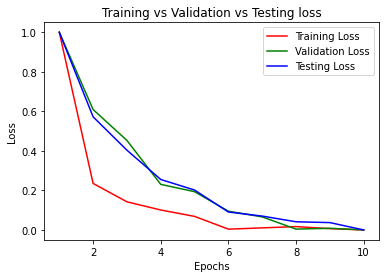

Accuracy on the testing dataset = 83.95


In [399]:
normalizedLossesPlot()
perfEvaluation()

## Performance Improvement

With our initial model parameters, we are close to achieve our model accuracy goal of >=85%. From the above graph of Training vs Validation vs Testing Loss, we don't see increase in validation loss during the entire training. Therefore we didn't select Early Stopping as a peformance improvement method. 
Let's try changing the below parameters for better performance of the model:

<b>Initial Model:</b><br>
Activation Function = ReLU<br>
Optimizer = optim.SGD(modelCNN.parameters(), lr=0.001, momentum=0.9)

<b>Updated Model:</b><br>
Activation Function = SeLU<br>
Optimizer = optim.Adam(modelCNN.parameters(), lr=0.001)

### Improved CNN architecture

1. How many input neurons are there?<br>
--> image size = 28\*28 and channels = 3. Therefore, number of input neurons = 28\*28\*3 = <b>2352</b><br>
1. How many output neurons are there?<br>
--> number of output neurons = number of classes in final layer i.e. fc3 = <b>36</b><br>
1. What activation function is used for the hidden layers?<br>
--> <b>SELU</b> activation function is used for hidden layers<br>
1. What activation function is used for the output layer? <br>
--> No activation function is used while defining CNN for output layers. It simply outputs logits and later we use <b>Softmax</b> activation function for computing classifications.<br>
1. What is the number of hidden layers?<br>
--> Total number of layers = <b>5</b>, in which conv1 is input layer and fc3 is output layer. Therefore, hidden layer = total layers - input layer - output layer = 5 - 1 - 1 = <b>3</b><br>
1. What is the kernel size, number of filters, strides, paddings and other CNN-parameters?<br>
--> For conv1: Kernel size = <b>5x5</b>, number of filters = <b>6</b>, Similarly, for conv2: Kernel size = <b>5x5</b>, number of filters = <b>16</b>. Max pooling layer: Kernel size = <b>2*2</b>, stride = <b>2</b>, Padding is not mentioned: therefore default Padding value is used i.e. <b>0</b><br>
1. Do you include Dropout?<br>
--> <b>No</b> Dropout isn't included

In [387]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 36)

    def forward(self, x):
        x = self.pool(F.selu(self.conv1(x)))
        x = self.pool(F.selu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.selu(self.fc1(x))
        x = F.selu(self.fc2(x))
        x = self.fc3(x)
        return x

In [388]:
modelCNN_updated = CNN()
print(modelCNN_updated)

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=36, bias=True)
)


In [389]:
# Torchinfo Summary
torchinfoSummary = torchinfo.summary(modelCNN_updated, input_data=torch.randn(batch_size, 3, 28, 28)) #batch_size=16, channels=3, height=28, width=28
print(torchinfoSummary)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [32, 36]                  --
├─Conv2d: 1-1                            [32, 6, 24, 24]           456
├─MaxPool2d: 1-2                         [32, 6, 12, 12]           --
├─Conv2d: 1-3                            [32, 16, 8, 8]            2,416
├─MaxPool2d: 1-4                         [32, 16, 4, 4]            --
├─Linear: 1-5                            [32, 120]                 30,840
├─Linear: 1-6                            [32, 84]                  10,164
├─Linear: 1-7                            [32, 36]                  3,060
Total params: 46,936
Trainable params: 46,936
Non-trainable params: 0
Total mult-adds (M): 14.76
Input size (MB): 0.30
Forward/backward pass size (MB): 1.21
Params size (MB): 0.19
Estimated Total Size (MB): 1.70


In [391]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelCNN_updated.parameters(), lr=0.001)

In [392]:
# Start time
startTime = time.time()

training_loss_plt_arr = []
validation_loss_plt_arr = []
testing_loss_plt_arr = []

epochs = 2
# Epoch Iteration
for epoch in range(epochs):
    training_loss = 0.0
    
    #Training loop
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = modelCNN_updated(inputs)
        loss_training = criterion(outputs, labels)
        loss_training.backward()
        optimizer.step()

        training_loss += loss_training.item()
        if i % 500 == 499:
            
            # Validation loop
            validation_loss = 0.0
            with torch.no_grad():
                for data in valloader:
                    images, labels = data
                    outputs = modelCNN_updated(images)
                    loss_validation = criterion(outputs, labels)
                    validation_loss += loss_validation.item()
            
            # Testing loop
            testing_loss = 0.0
            with torch.no_grad():
                for data in testloader:
                    images, labels = data
                    outputs = modelCNN_updated(images)
                    loss_testing = criterion(outputs, labels)
                    testing_loss += loss_testing.item()

            print(f"[{epoch + 1}, {i + 1}], Training loss: {training_loss / 500:.3f}, Validation loss: {validation_loss / len(valloader):.3f}, Testing loss: {testing_loss / len(testloader):.3f}")
            training_loss_plt_arr.append(round((training_loss / 500),3))
            validation_loss_plt_arr.append(round((validation_loss / len(valloader)),3))
            testing_loss_plt_arr.append(round((testing_loss / len(testloader)),3))
            training_loss = 0.0

print("Finished Training")
    
# End time
endTime = time.time()
time_to_train = (endTime - startTime)
print(f"\nTime to train = {time_to_train:.2f}\n")

[1, 500], Training loss: 1.096, Validation loss: 0.569, Testing loss: 0.568
[1, 1000], Training loss: 0.504, Validation loss: 0.474, Testing loss: 0.464
[1, 1500], Training loss: 0.432, Validation loss: 0.436, Testing loss: 0.423
[1, 2000], Training loss: 0.400, Validation loss: 0.382, Testing loss: 0.387
[1, 2500], Training loss: 0.375, Validation loss: 0.373, Testing loss: 0.374
[2, 500], Training loss: 0.325, Validation loss: 0.349, Testing loss: 0.347
[2, 1000], Training loss: 0.330, Validation loss: 0.342, Testing loss: 0.342
[2, 1500], Training loss: 0.335, Validation loss: 0.327, Testing loss: 0.335
[2, 2000], Training loss: 0.327, Validation loss: 0.328, Testing loss: 0.334
[2, 2500], Training loss: 0.322, Validation loss: 0.326, Testing loss: 0.325
Finished Training

Time to train = 325.70



In [393]:
# Updated Normalize Losses for better visualisation
def normalizedLossesPlotUpdated():
    training_loss_plt_arr_max = max(training_loss_plt_arr)
    training_loss_plt_arr_min = min(training_loss_plt_arr)
    validation_loss_plt_arr_max = max(validation_loss_plt_arr)
    validation_loss_plt_arr_min = min(validation_loss_plt_arr)
    testing_loss_plt_arr_max = max(testing_loss_plt_arr)
    testing_loss_plt_arr_min = min(testing_loss_plt_arr)

    training_loss_minmax_deno = training_loss_plt_arr_max - training_loss_plt_arr_min
    validation_loss_minmax_deno = validation_loss_plt_arr_max - validation_loss_plt_arr_min
    testing_loss_minmax_deno = testing_loss_plt_arr_max - testing_loss_plt_arr_min

    training_loss_plt_arr_norm = [(i - training_loss_plt_arr_min)/training_loss_minmax_deno for i in training_loss_plt_arr]
    validation_loss_plt_arr_norm = [(i - validation_loss_plt_arr_min)/validation_loss_minmax_deno for i in validation_loss_plt_arr]
    testing_loss_plt_arr_norm = [(i - testing_loss_plt_arr_min)/testing_loss_minmax_deno for i in testing_loss_plt_arr]

    # Plot the loss graph
    plt.plot(range(1, 11), training_loss_plt_arr_norm, label='Training Loss', color='red')
    plt.plot(range(1, 11), validation_loss_plt_arr_norm, label='Validation Loss', color='green')
    plt.plot(range(1, 11), testing_loss_plt_arr_norm, label='Testing Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation vs Testing loss')
    plt.legend()
    plt.show()

In [396]:
# Updated Performance Evaluation
import seaborn as sns
def loadersAccuracy(loader):
    modelCNN_updated.eval()
    correct = 0
    total = 0
    trueLabels, predictedLabels = [], []
    trueLabelsROC, predictedLabelsROC = [], []

    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = modelCNN_updated(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            trueLabels.extend(labels.tolist())
            predictedLabels.extend(predicted.tolist())
            #ROC
            preds = F.softmax(outputs, dim=1)
            trueLabelsROC.extend(labels.tolist())
            predictedLabelsROC.extend(preds.tolist())
    
    accuracy = (correct / total * 100)
    return accuracy, trueLabels, predictedLabels, trueLabelsROC, predictedLabelsROC

def perfEvaluationUpdated():
    modelCNN.eval()
        
    # Accuracies
    test_accuracy, test_trueLabels, test_predictedLabels, test_trueLabelsROC, test_predictedLabelsROC= loadersAccuracy(testloader)
    print(f"Accuracy on the testing dataset = {test_accuracy:.2f}")

    valid_accuracy, _, _, _, _= loadersAccuracy(valloader)
    train_accuracy, _, _, _, _= loadersAccuracy(trainloader)

    # Convert labels and predicted from list to tensor for metric calucaltions
    test_predictedLabels = torch.tensor(test_predictedLabels)
    test_trueLabels = torch.tensor(test_trueLabels)
    test_trueLabelsROC = torch.tensor(test_trueLabelsROC)
    test_predictedLabelsROC = torch.tensor(test_predictedLabelsROC)


    # Precision, Recall, Fscore
    precision, recall, fscore, _ = precision_recall_fscore_support(test_trueLabels, test_predictedLabels, average='weighted')
    print(f"Precision = {precision:.2f}")
    print(f"Recall = {recall:.2f}")
    print(f"Fscore = {fscore:.2f}")

    # Plot the Accuracies
    labels = ['Training', 'Validation', 'Test']
    accuracies = [train_accuracy, valid_accuracy, test_accuracy]
    plt.bar(labels, accuracies, color=['red', 'green', 'blue'])
    plt.xlabel('Splits')
    plt.ylabel('Accuracy')
    plt.title('Accuracies')
    for i, v in enumerate(accuracies):
        plt.text(i, v + 1, f'{v:.2f}', color='black', ha='center')
    plt.show()

    # Plot Confusion Matrix
    cm = confusion_matrix(test_trueLabels, test_predictedLabels)
    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted class")
    plt.ylabel("True class")
    plt.show()

    # Plot ROC Curve
    metric = MulticlassROC(num_classes=36)
    metric.update(test_predictedLabelsROC, test_trueLabelsROC)
    metric.plot(score=True)


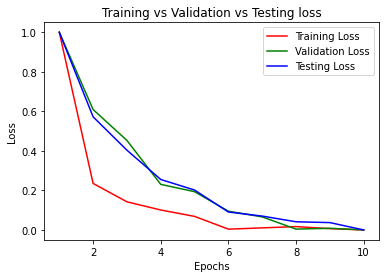

Accuracy on the testing dataset = 88.17
Precision = 0.89
Recall = 0.88
Fscore = 0.88


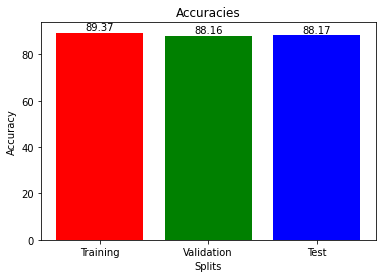

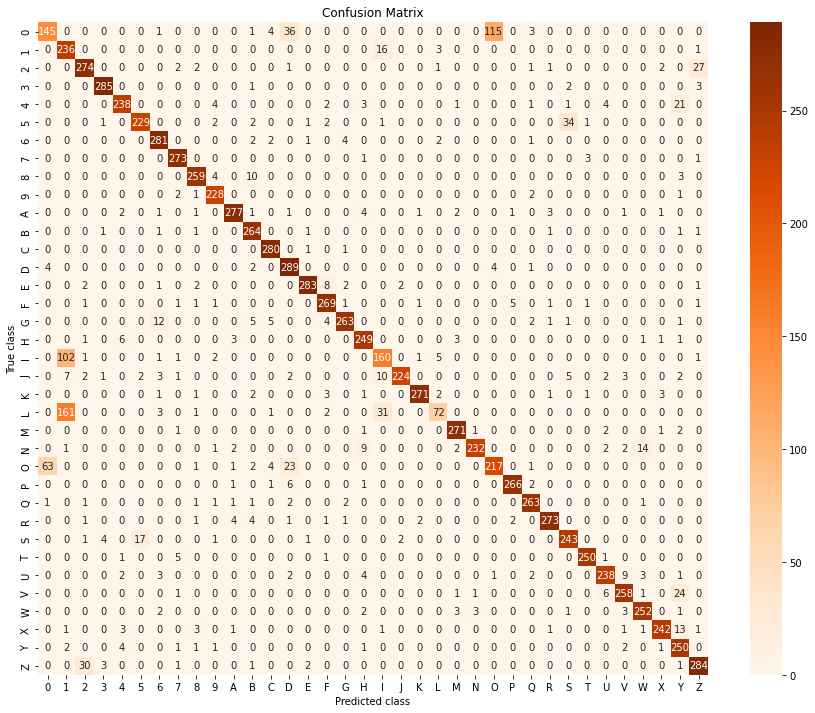

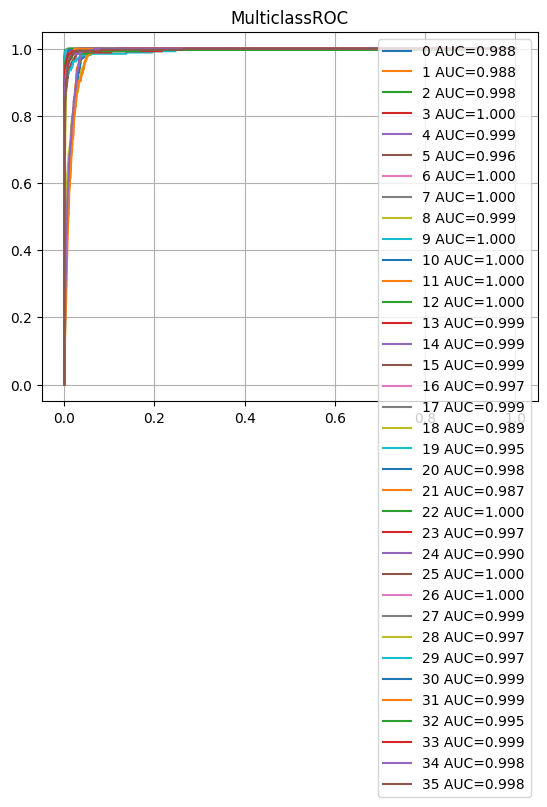

In [397]:
normalizedLossesPlotUpdated()
perfEvaluationUpdated()